#### Oğulcan Ulu
#### Matricola Number: 2105922
#### Cognition and Computation Project 2024/2025

# Generative Models of Visual Perception: A Comparison of VAE and ß-VAE on Caltech 101


This project aims to explore the representational capacity of VAEs and ß-VAEs trained on the **Caltech 256** dataset. We focus on:
- The quality of **latent representations** and their **disentanglement**
- The **robustness** of these models under noise and few-shot learning
- Visualization and clustering of learned internal features

From a neuroscientific perspective, this study connects to how hierarchical areas of the visual cortex from V1 to IT encode increasingly abstract features.

---

### Project Goals
1. Compare **VAE** and **ß-VAE** on a visual concept learning task.
2. Analyze the **structure and disentanglement** of their internal latent spaces.
3. Evaluate **classification performance** via linear readouts from latent embeddings.
4. Explore robustness via **noise perturbations** and **few-shot generalization**.
5. Visually interpret model behavior using **embedding visualizations**.

---

### Dataset

Dataset we will use in this project is **Caltech 101** is a subset of Caltech 256. We will use it for the sake of computational efficiency. Pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images.

Li, F.-F., Andreeto, M., Ranzato, M., & Perona, P. (2022). Caltech 101 (1.0) [Data set]. CaltechDATA. https://doi.org/10.22002/D1.20086


We will start with uploading and checking data.

---

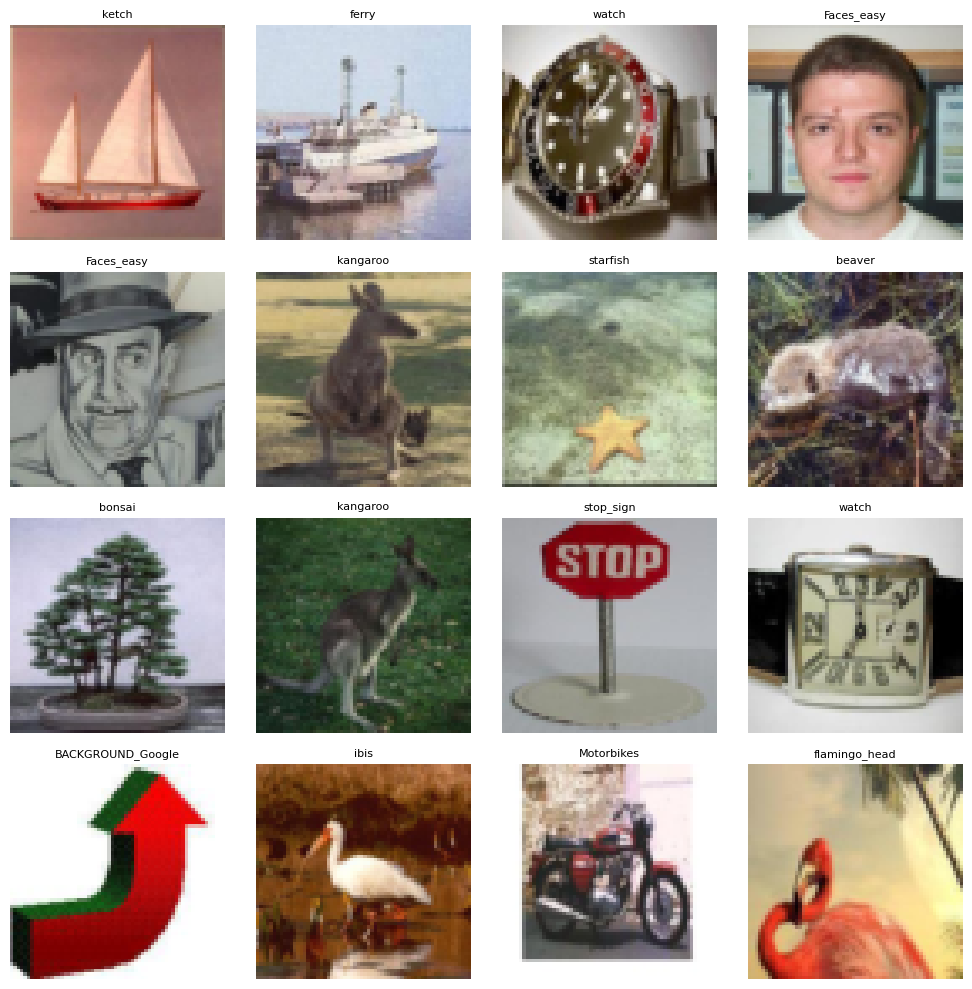

In [1]:
!pip install numpy
!pip install matplotlib
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random

#defining transformation for dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  #Normalize to -1, 1
])

#loading dataset
dataset_path = '/Users/ogulcanulu/Desktop/UNIPD 2024-2025/Cognition and Computation/dataset_for_project/caltech-101/101_ObjectCategories'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

#shuffling before visualization to prevent not getting images from same folder
def get_random_subset(dataset, num_samples=16):
    indices = random.sample(range(len(dataset)), num_samples)
    return Subset(dataset, indices)

#visualizing few images
def visualize_sample(dataset_subset):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img, label = dataset_subset[i]
        class_name = dataset.classes[label]
        ax.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
        ax.axis('off')
        ax.set_title(class_name, fontsize=8)
    plt.tight_layout()
    plt.show()

subset = get_random_subset(dataset, num_samples=16)
visualize_sample(subset)

In [8]:
#splitting dataset into training and test

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

---

## Model Architecture ß-VAE

In this project, I use a simplified version of the **ß-Variational Autoencoder (ß-VAE)**, a generative model designed to compress visual input into a small internal code (latent space) and then reconstruct the input from that.


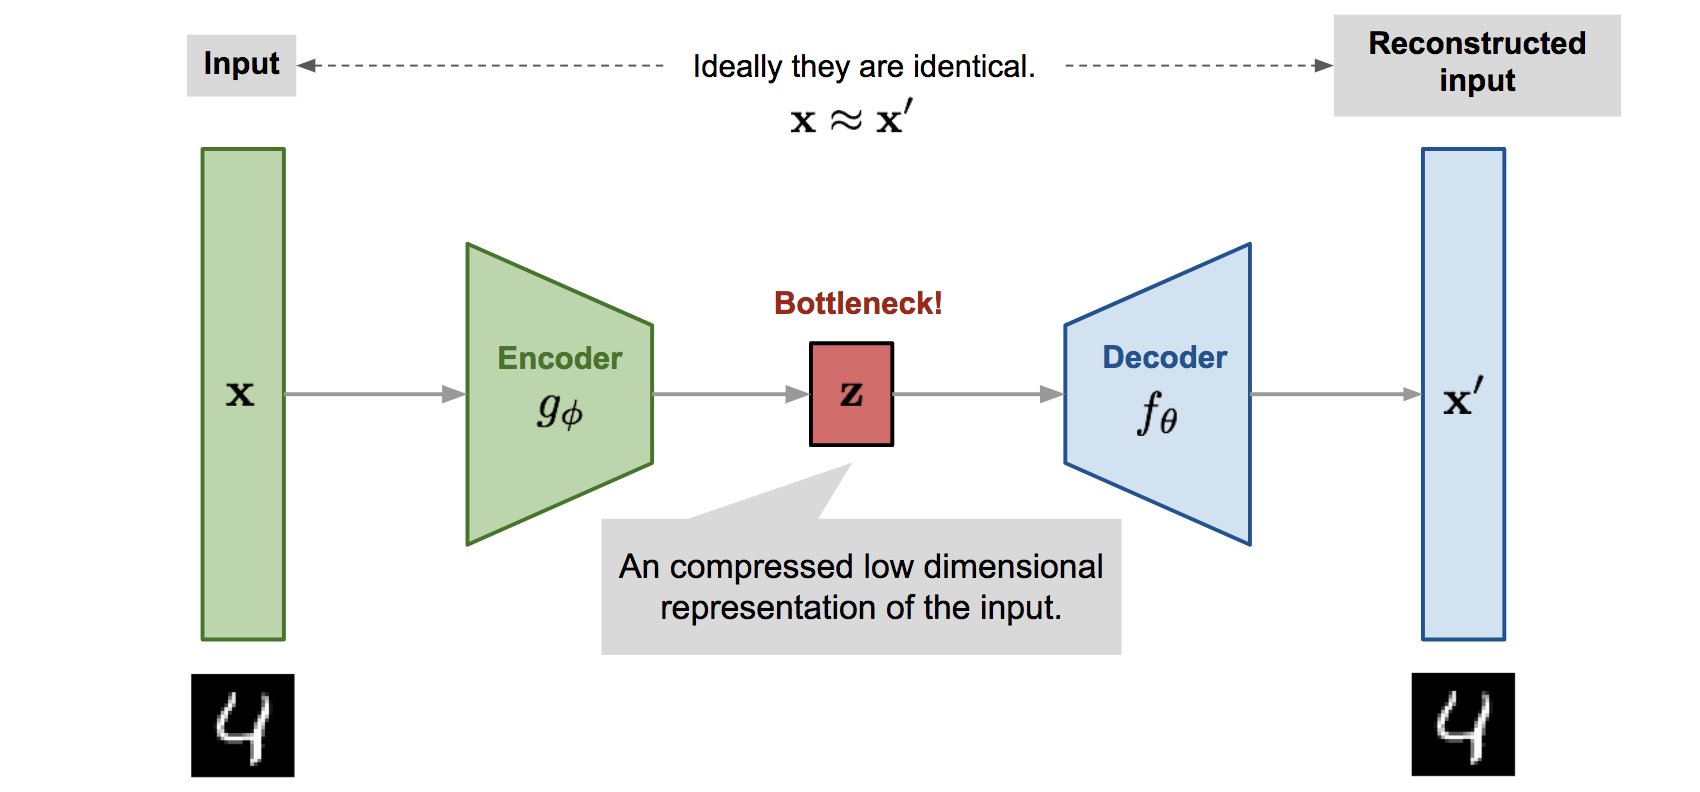

---

- The **encoder** compresses visual input to a low dimensional latent vector (`mu`, `logvar`)
- The **latent space** is sampled using the reparameterization trick to allow backpropagation
- The **decoder** reconstructs the image from the latent space

---

The ß-VAE adds a parameter `ß` to the loss function to control the tradeoff between:
- **Reconstruction accuracy** how well the image is recreated
- **Latent space structure** how abstract or disentangled the internal code is

---

This architecture is an extension of the models explored in lab practice:

- It is applied here to **Caltech-101**, a dataset of real-world object categories with RGB images resized to 64×64 pixels.

- The latent representation captures higher level visual concepts (shape, structure) beyond pixel details.


---

- In **predictive coding theory**, the brain is thought to continually generate internal predictions of sensory input and compare them to actual stimuli. A VAE mirrors this by reconstructing from a latent prediction.
- Under the **Bayesian brain hypothesis**, perception is modeled as probabilistic inference. The VAE reflects this with its stochastic latent variables (`μ`, `σ`) and sampling.
- Higher ß values emphasize **disentanglement** to hierarchical visual areas separating object identity from low level visual features and pixel to pixel representations.


---

DiCarlo, J. J., Zoccolan, D., & Rust, N. C. (2012). How Does the Brain Solve Visual Object Recognition? Neuron, 73(3), 415–434. https://doi.org/10.1016/j.neuron.2012.01.010

Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., Mohamed, S., & Lerchner, A. (2017, February 6). beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework. International Conference on Learning Representations. https://openreview.net/forum?id=Sy2fzU9gl

Knill, D. C., & Pouget, A. (2004). The Bayesian brain: The role of uncertainty in neural coding and computation. Trends in Neurosciences, 27(12), 712–719. https://doi.org/10.1016/j.tins.2004.10.007

Rao, R. P. N., & Ballard, D. H. (1999). Predictive coding in the visual cortex: A functional interpretation of some extra-classical receptive-field effects. Nature Neuroscience, 2(1), 79–87. https://doi.org/10.1038/4580



In [2]:
import torch
import torch.nn as nn

#defining model architecture

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()  #after flattening 128*8*8 = 8192 input
        )

        self.fc_mu = nn.Linear(8192, latent_dim)
        self.fc_logvar = nn.Linear(8192, latent_dim)

        #decoder
        self.decoder_input = nn.Linear(latent_dim, 8192)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x): #it defines the workflow from input image to output image
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## VAE Loss Function and Optimizer

The training objective of a Variational Autoencoder balances two goals:

1. **Reconstruction Loss** Ensures the decoder can accurately reconstruct input images.
   - Typically measured using **Mean Squared Error (MSE)** or **Binary Cross Entropy (BCE)**.

2. **KL Divergence** – Ensures the learned latent distribution stays close to a standard distribution.
   - Acts as a penalizer to prevent overfitting.

---

We now define this loss function and set up the optimizer to begin training.


In [3]:
import torch.nn.functional as funct

#loss function
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    #reconstruction loss I will use mean squared error
    recon_loss = funct.mse_loss(recon_x, x, reduction='sum')

    #KL Divergence normal distribution
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_div

#optimizer
def get_vae_optimizer(model, lr=1e-3):
    return torch.optim.Adam(model.parameters(), lr=lr)


## VAE Training Loop

To train the VAE, we follow a typical supervised learning loop with one difference, instead of predicting labels our aim is to reconstruct inputs from a compressed latent space.

### Steps per training epoch
1. Encode input to latent space
2. Sample from the latent distribution
3. Decode to reconstruct the input
4. Compute the VAE loss:
   - **Reconstruction loss** (MSE in our case)
   - **KL divergence** between q(z|x) and standard Gaussian
5. Backpropagate and update parameters

In [4]:
def train_vae(model, dataloader, optimizer, device, beta, epochs):
    model.train()
    loss_history= [] #to use for plotting
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in dataloader:
            images = images.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(images)
            loss = vae_loss_function(recon, images, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)
    return loss_history

---

We have defined the training function. Now we can proceed with training the model. But before it is important to highlight that;

Neural networks require a lot of computation, especially when training on a large dataset as I have here. Before training the model it would be important to run one of the important setup step determining whether my machine has GPU or just a cpu.

PyTorch supports two types of "devices":
- **CPU**: Slower, but always available
- **GPU**: Much faster for deep learning, but only available if the machine has a compatible NVIDIA GPU and drivers installed
---

In [5]:
 print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

False
cpu


---
**Well, this is a sign of "good luck with your training".** in my lines of codes it returned that cuda is not available, means that I am using cpu which is totally fine, just slower.

---

In [6]:
#assigning device, model and optimizer to a variable to use them in an easier way
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #previously shown that it uses cpu
model = VAE(latent_dim=64).to(device)
optimizer = get_vae_optimizer(model)

In [9]:
#now I am running the model to train
vae_b1_10 = VAE(latent_dim=64).to(device)
opt_b1_10 = get_vae_optimizer(vae_b1_10)

losses_b1_10 = train_vae(
    model=vae_b1_10,
    dataloader=train_loader,
    optimizer=opt_b1_10,
    device=device,
    beta=1,
    epochs=10
)

#### Before visualizing

Instead of writing visualization codes for each model I will define a function beforehand to use later.

In [10]:
import matplotlib.pyplot as plt

def plot_training_loss(losses, label, title):
    plt.plot(losses, marker='o', label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [11]:
def show_vae_reconstructions(model, dataloader, device, num_images=8):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        recon, _, _ = model(images)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        #toprow original
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[0, i].axis("off")

        #bottomrow reconstructions
        axes[1, i].imshow(recon[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].axis("off")

    plt.suptitle("VAE Reconstruction Results", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### Now time to visualize the results

To evaluate how well the VAE has learned to represent visual data, we compare a batch of **original test images** with their **reconstructions**.

This lets us see:
- What features the VAE is capturing
- Whether the latent space contains meaningful abstractions
- How fidelity changes with different `ß` values

Below original images and reconstructed images can be appreciated.

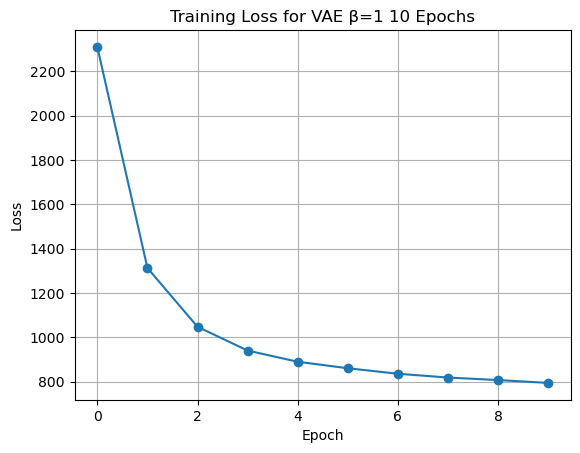

In [ ]:
plot_training_loss(losses_b1_10, label='ß=1 30 epochs', title="Training Loss for VAE ß=1 10 Epochs")

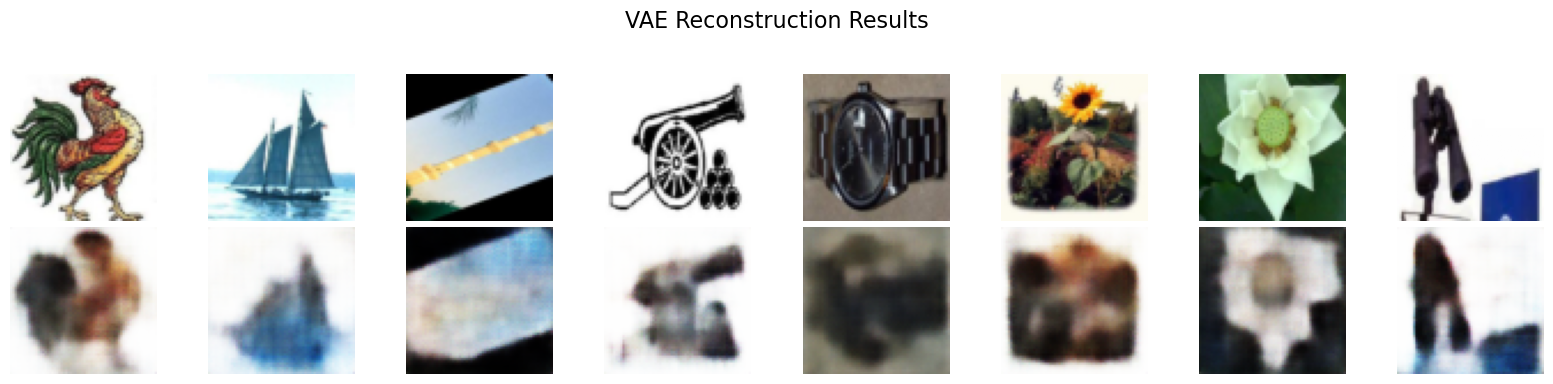

In [ ]:
show_vae_reconstructions(vae_b1_10, train_loader, device, num_images=8)

---

I did not really like the results. So I will proceed with increasing epoch to 30. That will allow model to spend more time to learn. In another words each epoch is the one full pass through entire training images. With 10 epochs model saw each image 10 times but with 30 it will spend more time to learn dataset.

Increasing epoch is like **perceptual learning** where experience enhances our ability to perceive and interpret stimuli.

---

In [12]:
#retraining with 30 epochs while keeping the beta 1
vae_b1_30 = VAE(latent_dim=64).to(device)
opt_b1_30 = get_vae_optimizer(vae_b1_30)

losses_beta1_30 = train_vae(
    model=vae_b1_30,
    dataloader=train_loader,
    optimizer=opt_b1_30,
    device=device,
    beta=1,
    epochs=30
)

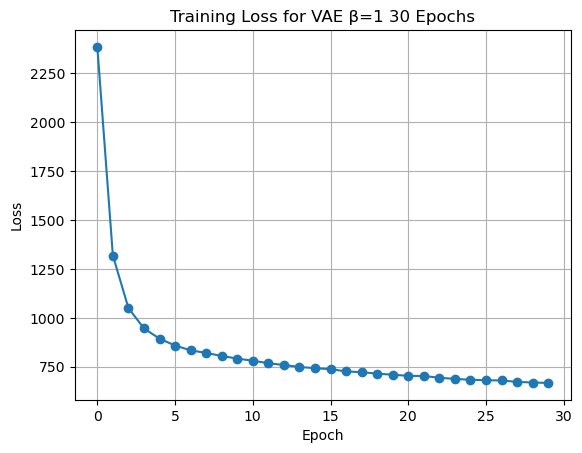

In [ ]:
plot_training_loss(losses_beta1_30, label="ß=1 30 epochs", title="Training Loss for VAE ß=1 30 Epochs")

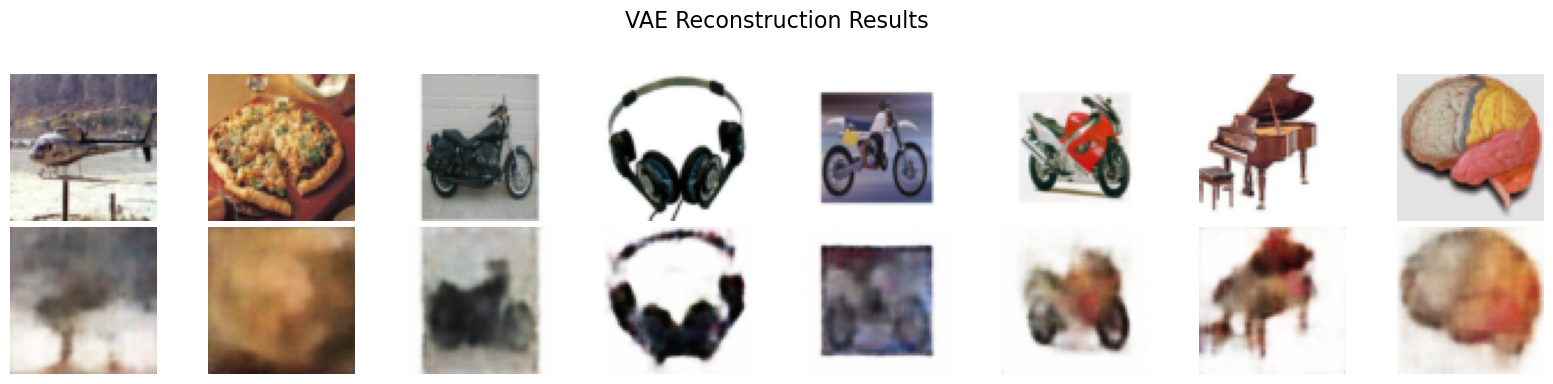

In [ ]:
show_vae_reconstructions(vae_b1_30, train_loader, device, num_images=8)

## VAE Results (ß = 1)

The loss curve reveals a steep decline in the first few epochs, indicating that the model rapidly learns to capture basic visual features such as color blobs, edges, and general outline of object.

However, as training progresses beyond, the loss curve begins to flatten, suggesting that the model is approaching a plateau in its ability to minimize reconstruction error. Once simple features are learned, further improvements rely on capturing finer, more abstract representations.

This learning pattern mirrors **perceptual tuning**

**Early learning:** Similar to how the visual cortex quickly adapts to dominant features in new stimuli.

**Later epochs:** The model needs more training to refine subtle structures, similar to perceptual learning in the brain.

---

Model reflects key principles from **predictive coding** and **Bayesian brain** theories:

- The **encoder** builds compressed internal representations of visual input. Similar to how early visual areas (like V1/V2) extract structured patterns in the visual field.
- The **decoder** attempts to reconstruct the sensory world from internal beliefs much like cortical feedback loops in predictive coding models.

---

- Reconstructed images retain **high level object structure**, but fine details are blurred.
- The VAE forms a **compressed latent space**, where perceptual features to be encoded efficiently.
- This mimics how the **ventral visual stream** abstracts features progressively toward invariant object identity.

---

### What About Chaning ß?

By increasing ß > 1, we will encourage **disentangled and abstract latent features**, possibly sacrificing visual fidelity in favor of *conceptual clarity*. Would look much like how higher visual areas generalize across variation.

To explore how stronger regularization affects the structure of internal representations, we now train `ß = 4`.

This model places greater emphasis on **disentangling latent factors** rather than optimizing perfect input-output reconstructions. analogous to how the brain abstracts invariant concepts from variable input.

We use the same architecture, dataset, and optimizer settings as in the baseline VAE for a fair comparison.

In [13]:
#Training ß=4 30 epochs
vae_b4_30 = VAE(latent_dim=64).to(device)
opt_b4_30 = get_vae_optimizer(vae_b4_30)

losses_b1_10 = train_vae(
    model=vae_b4_30,
    dataloader=train_loader,
    optimizer=opt_b4_30,
    device=device,
    beta=4,
    epochs=30
)

In [ ]:
losses_b4_30 = losses_b1_10 #I forgot to change the name of the losses

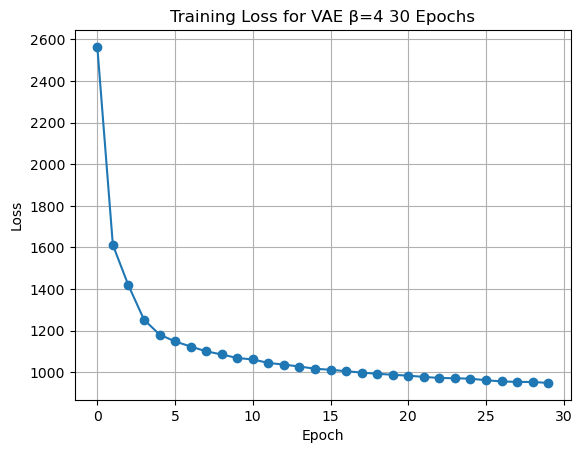

In [ ]:
plot_training_loss(losses_b4_30, label="ß=4 30 epochs", title="Training Loss for VAE ß=4 30 Epochs")

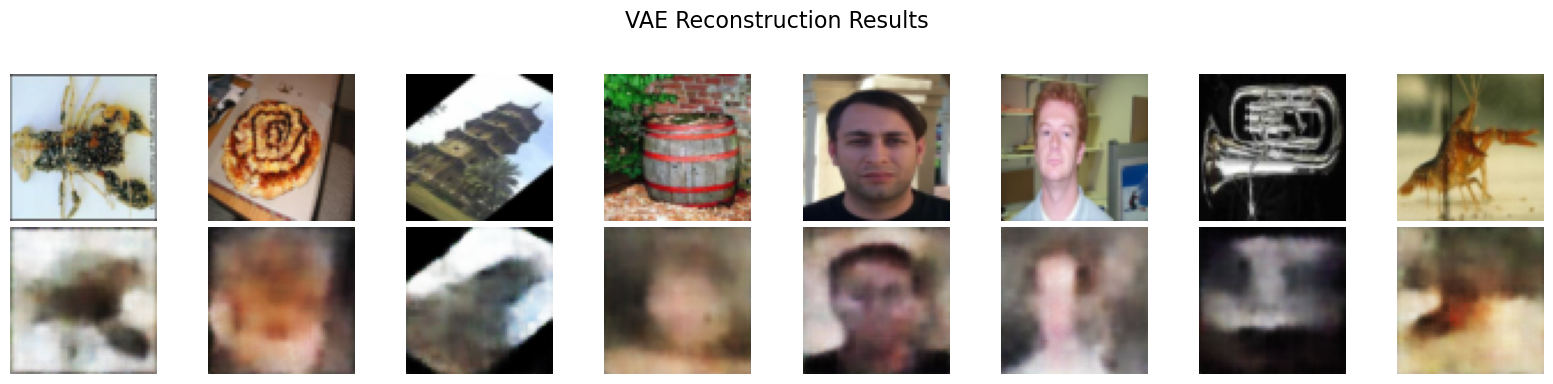

In [ ]:
show_vae_reconstructions(vae_b4_30, train_loader, device, num_images=8)

## ß-VAE Results (ß = 4)

With a ß-VAE trained at `ß = 4` for 30 epochs, we observe a new balance between **reconstruction fidelity** and **latent structure regularization**.

---

The loss decreases steadily, similar to ß=1. With slightly higher baseline indicating KL Divergence penalty.

---

- Reconstructions remain **blurry** and **less visually sharp** compared to the input, especially in complex regions like faces or textures.
- However, the model retains **object level structure** it's not memorizing pixels, but abstracting concepts.
- This behavior is consistent with the ß-VAE's goal: **learn disentangled, high level generative features** rather than overfitting details.

### Perceptual Ambiguity and Illusions in ß-VAE Reconstructions

A perfect example occured in the visualized reconstructions.

![Instance](https://i.ibb.co/xKcZ57NW/Screenshot-2025-05-24-at-14-43-14.png)


**In the fourth reconstruction example. The original image shows a barrel, yet the reconstructed output seems like a human face. This may reflect how the ß-VAE, with stronger abstraction pressure, compresses and reconstructs based on learned conceptual priors rather than strict pixel to pixel accuracy. This example can be a mirror of a perceptual illusions arise when internal predictions override ambiguous sensory input causing the brain to interpret a stimulus based on prior experience or expected patterns.**

---

In terms of cognitive modeling:
- A higher ß mirrors the **Bayesian brain hypothesis**: strong priors and abstract internal codes outweigh exact stimulus matching.
- It reflects **hierarchical perception** as we ascend cortical pathways (from V1 to IT cortex), neurons respond **less to precise input** and **more to invariant category features**.
- The ß-VAE’s push toward abstraction parallels how the brain encodes **concepts** and **categorizes** like "face" or "instrument" despite visual variability.

---

Let's also explore model with ß=10

In [14]:
#Training ß=10 30 epochs
vae_b10_30 = VAE(latent_dim=64).to(device)
opt_b10_30 = get_vae_optimizer(vae_b10_30)

losses_b10_30 = train_vae(
    model=vae_b10_30,
    dataloader=train_loader,
    optimizer=opt_b10_30,
    device=device,
    beta=10,
    epochs=30
)

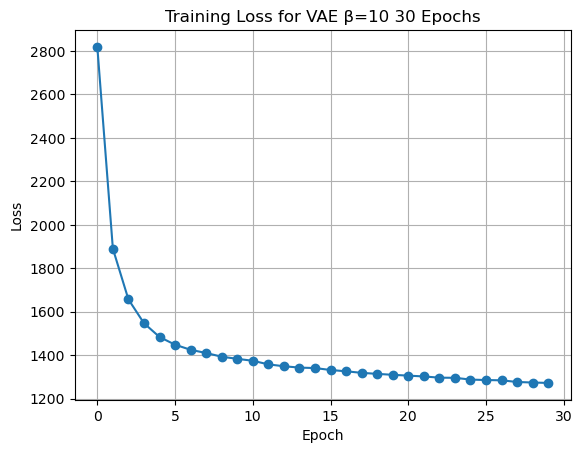

In [ ]:
plot_training_loss(losses_b10_30, label="ß = 10 30 epochs", title="Training Loss for VAE ß=10 30 Epochs")

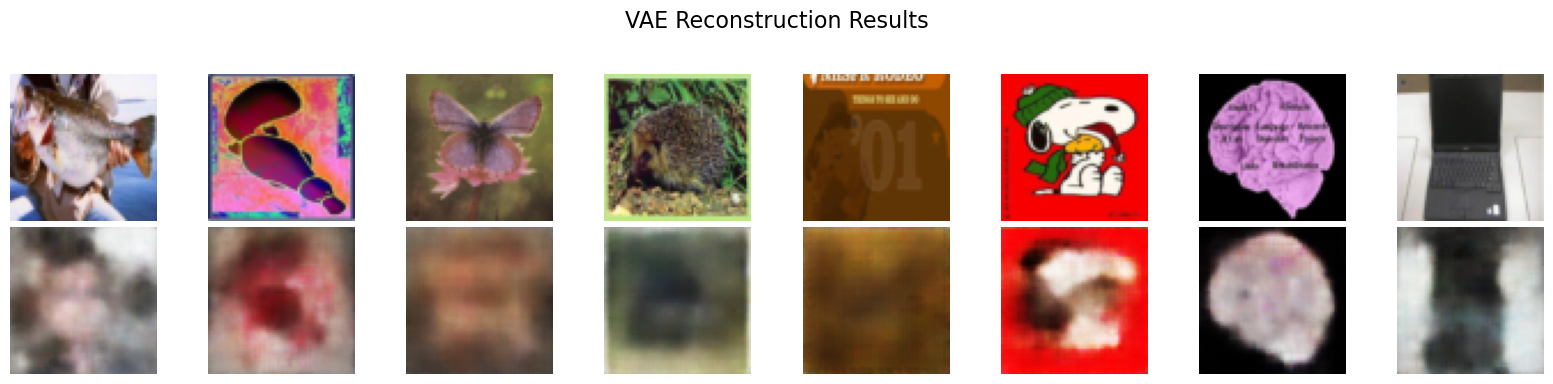

In [ ]:
show_vae_reconstructions(vae_b10_30, train_loader, device, num_images=8)

## ß-VAE Results (ß = 10)

Training with ß = 10 dictates strong regularization on the latent space. This pushes the model to favor **high-level abstraction and disentanglement** over low-level visual detail.

---

- The loss begins much higher than ß=1 and ß=4 — reflecting the **strong penalty on KL divergence**.
- It decreases more gradually, but flattens at a higher value compared to ß=1.
- This confirms that the model is **learning to prioritize structured internal codes** over perfect image reconstructions.

---

- Reconstructions are notably more **blurry**, and **symbolic**.
- Fine details are often lost, but **layout, color theme, and object position remain**.
---

This behavior aligns with **abstraction in cortical hierarchy**:
- Early visual areas encode **precise sensory features**
- Higher areas encode **conceptual identity** even if sensory details vary
- The ß-VAE with ß=10 behaves similarly, enforcing **latent simplicity** with the cost of losing output precision

---

- ß=10 leads to the most **disentangled**, but least **detailed** reconstructions
- Mirrors how cognition sometimes favors **category level generalization** over sensory input

---

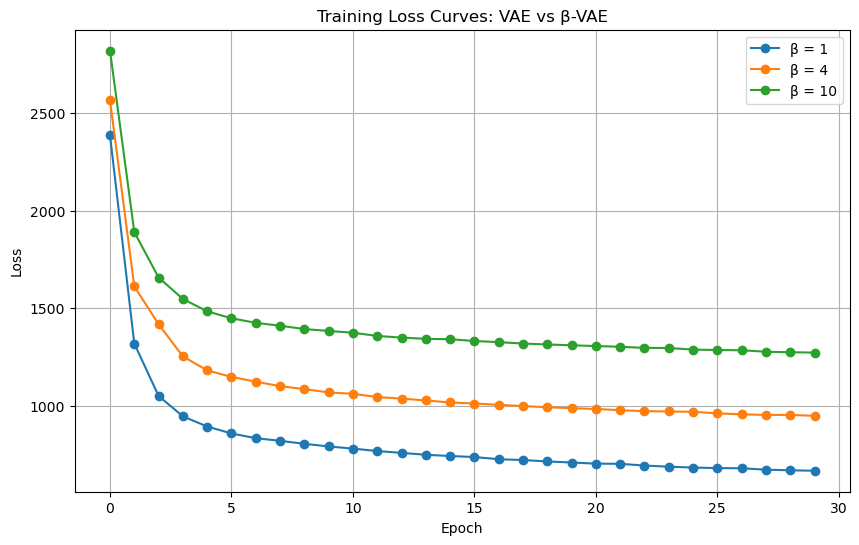

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison_loss(losses_list, labels, title="Training Loss Comparison", ylabel="Loss"):
    plt.figure(figsize=(10, 6))
    for losses, label in zip(losses_list, labels):
        plt.plot(losses, marker='o', label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()
#plotting all three loss curves
plot_comparison_loss(
    losses_list=[losses_beta1_30, losses_b4_30, losses_b10_30],
    labels=["ß = 1", "ß = 4", "ß = 10"],
    title="Training Loss Curves: VAE vs ß-VAE"
)


- All models converge over ~30 epochs, but with differing final losses.

- The ß = 1 model achieves the lowest loss this makes sense, as it represents the early visual fields penalty for pixel to pixel accuracy is less compared to other ß values.

- As ß increases, the loss curve flattens at a higher level, indicating that the model is sacrificing reconstruction precision in favor of more structured latent space

ß = 4 shows a balanced trade-off.

ß = 10 leads to the highest loss, but also the strongest abstraction pressure

### Analyzing the Internal Structure of Latent Representations

To evaluate how different values of ß influence the **quality and structure** of the learned latent space, we begin by extracting and analyzing the posterior means from each trained VAE model.

These latent vectors represent the model's internal abstraction of the input images—and serve as the foundation for understanding **how disentangled**, **separable**, and **interpretable** these representations truly are.

---

Our analysis proceeds in multiple steps:

1. **Latent Extraction**  
   Each input image is passed through the encoder to obtain its corresponding latent vector

2. **Dimensionality Reduction (PCA)**  
   We reduce these high-dimensional vectors to 2D using **Principal Component Analysis (PCA)** to get an interpretable projection.

3. **Qualitative Visualization**  
   Each projected point is colored by its true class label, revealing whether semantically similar classes cluster together.

4. **Quantitative Evaluation**  
   To go beyond visual inspection, we also apply:
   - **Clustering algorithms (K-Means for this case)** to evaluate how naturally the data organizes.
   - **Linear classifiers** to test class separability in the latent space.
   - **Confusion matrices** to identify where the representations fail.

---

A well structured model would result in:
- Success in clustering
- Clear visual separation of categories
- Higher linear separability
- Lower classification confusion

### Latent Extraction

To begin our analysis, we extract the latent vectors from each trained ß-VAE model by passing the test dataset through the encoder.

Each image is mapped to a vector in the latent space this is the VAE’s internal representation of the input. We do this for every ß value separately (Since there are 3 different ß values ß = 1, 4, 10), using each model’s final state.

---
- We only use the **posterior means**, not samples from the latent distribution.
- We collect the latent vectors for all test images, along with their **true class labels**.

---

This step provides the raw material for every subsequent evaluation and application for clustering, projection, classification, and confusion matrix. It gives us a clean and consistent way to compare how different ß values affect the structure and expressiveness of the learned latent space.


In [17]:
import numpy as np

beta_models = {
    1: vae_b1_30,
    4: vae_b4_30,
    10: vae_b10_30
} #models I have trained

latent_data = {}  #empty set to store

for i, model in beta_models.items():
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, _ = model.encode(x)  # discard logvar
            all_mu.append(mu.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    latent_data[i] = (all_mu, all_labels)

    print(f"ß = {i}: μ shape = {all_mu.shape}, labels shape = {all_labels.shape}")


β = 1: μ shape = (1829, 64), labels shape = (1829,)
β = 4: μ shape = (1829, 64), labels shape = (1829,)
β = 10: μ shape = (1829, 64), labels shape = (1829,)


In [24]:
!pip install scikit-learn
def visualize_latents_pca(mu_array, label_array, beta_value):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    #reducing latent space to 2D with PCA
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(mu_array)

    #plotting
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        latents_2d[:, 0], latents_2d[:, 1],
        c=label_array, cmap="tab20", s=10, alpha=0.7
    )
    plt.colorbar(scatter, label="Class Label")
    plt.title(f"Latent Space (PCA Projection) — ß = {beta_value}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 350.6 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 515.2 kB/s eta 0:00:0000:0100:02
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pybids 0.19.0 requires pandas>=1.5, which is not installed.
pybids 0.19.0 requires sqlalchemy>=1.4.31, which is not installed.
nilearn 0.11.0 requires lxml, which is not installed.
nilearn 0.11.0 requires pandas>=2.2.0, which is not installed.
formulaic 1.1.1 requires pandas>=1.0, which is not installed.


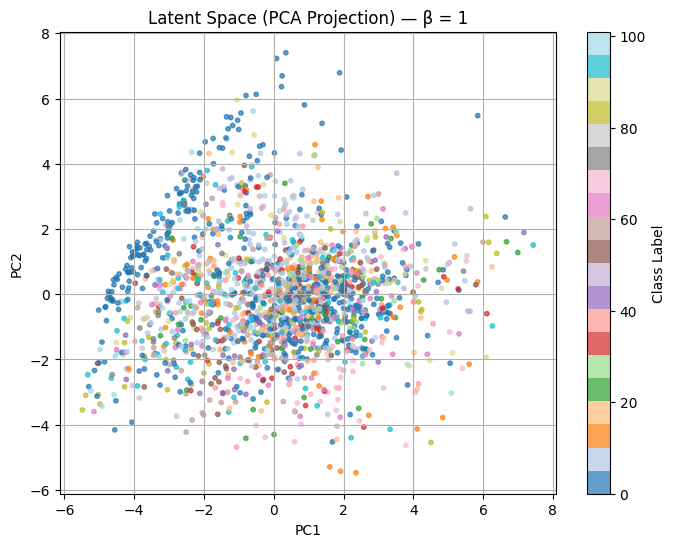

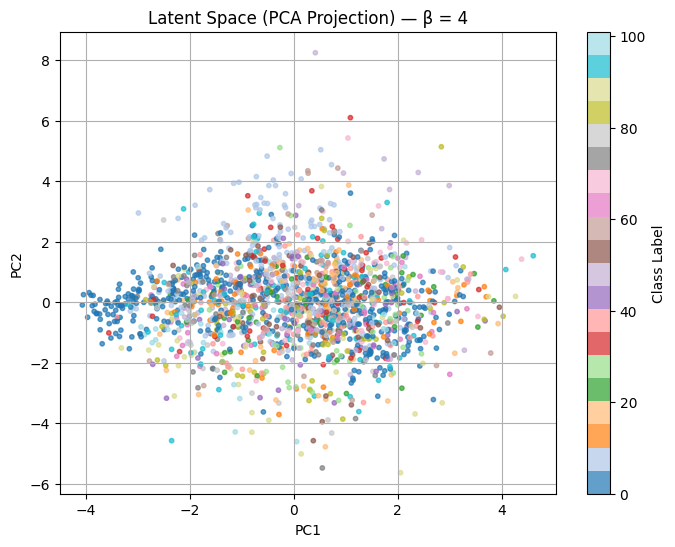

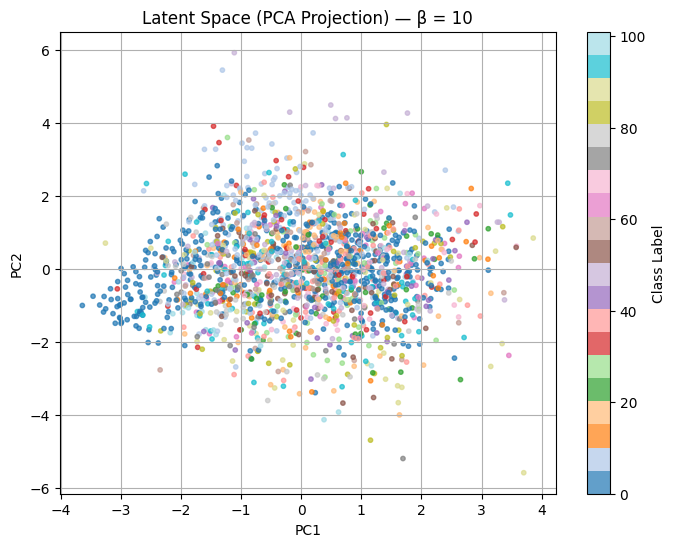

In [25]:
for i, (mu, labels) in latent_data.items():
    visualize_latents_pca(mu, labels, i)

### Well, that is a mess, they dont seem that informative visually.

The PCA projections above show how the latent representations (μ vectors) are distributed in 2D for different ß values: **ß = 1, 4, 10**. Each point represents an image, colored by its class label.

---

- **ß = 1:**  
  The latent space shows some scattered structure, but there's significant **overlap between classes**. This suggests that the representations are entangled and not clearly separable by category. We can only see some blue dot representations of the class on the up-left part of the graph.

- **ß = 4:**  
  The structure is slightly more flattened along PC1, and class clusters begin to **tighten slightly**, but the overlap is still strong. Some classes again mostly blue dot reporsented category start to form rough regions, indicating partial disentanglement.

- **ß = 10:**  
  The latent space appears **more compact**, and while classes are still mixed, there's a **clearer spatial spread** compared to ß=1. The reduced variance suggests that the model is focusing more on compressing abstract features, though possibly at the expense of fine class separation.

---

- Increasing ß forces the model to **prioritize compression and disentanglement** over pure reconstruction.
- As ß increases, we observe **greater regularity and compactness** in the latent space, but also potential **loss of class separability**.
- PCA projections give a **qualitative view**, which we will now complement with **quantitative measures** like clustering and classification performance.

## Visualization with t-SNE

After exploring the latent representations with **PCA**, we observed that while it provides a basic projection of the latent space, the plots appear **heavily overlapped** and **not clearly informative**. PCA is a linear technique, and while useful for understanding global variance, it may not capture the non linear structure of highdimensional latent spaces learned by VAEs.

We apply **t-distributed Stochastic Neighbor Embedding (t-SNE)**, a non-linear dimensionality reduction technique that excels at preserving **local neighborhood structure**. This allows us to better observe whether latent representations cluster semantically based on object categories.

In the following plots, we apply t-SNE to the same latent vectors extracted from each ß-VAE model. Each point still represents an image, and colors indicate its true class. Unlike the PCA results, we expect t-SNE to reveal tighter groupings of samples from the same category

This gives us a more **qualitative sense of semantic organization** in the latent space and complements our earlier analysis using PCA and silhouette scores.


In [83]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latents_tsne(mu_array, label_array, beta_value):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    latents_2d = tsne.fit_transform(mu_array)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        latents_2d[:, 0], latents_2d[:, 1],
        c=label_array, cmap='tab20', s=8, alpha=0.7
    )
    plt.colorbar(scatter, label='Class Label')
    plt.title(f't-SNE of Latent Representations — ß = {beta_value}')
    plt.xlabel('t-SNE  1')
    plt.ylabel('t-SNE  2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


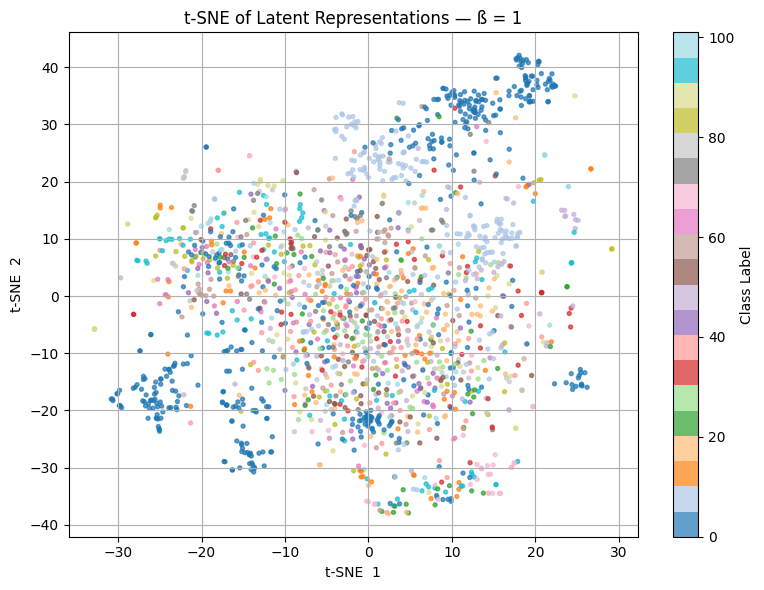

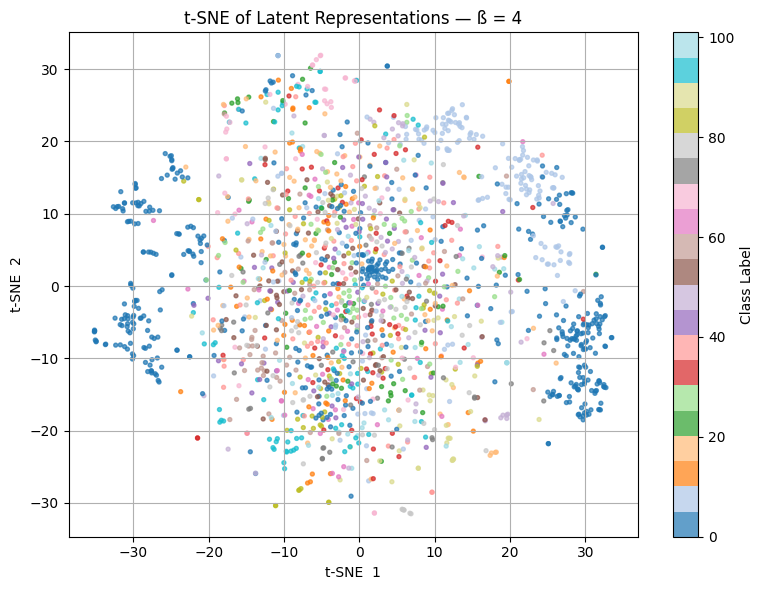

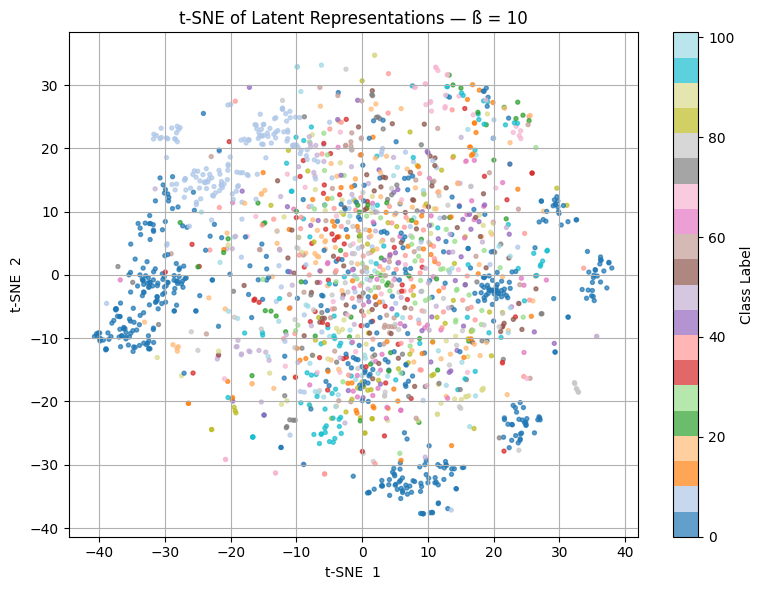

In [84]:
for beta_value, (mu, labels) in latent_data.items():
    visualize_latents_tsne(mu, labels, beta_value)

---

#### ß = 1 :
- There are **some clusters**, However, the majority of the latent space is **densely mixed**, with **significant class overlap**. This reflects an **entangled latent space**, where the model doesn't effectively separate object categories.

#### ß = 4:
- The distribution is more **spherical and symmetric**, suggesting increased regularity compared to previous ß=1
- Some local grouping is more pronounced than in ß=1, but **inter class mixing is still high**.
- It shows **partial disentanglement**, but still not enough to produce clearly defined class clusters.

#### ß = 10:
- The clusters are **tighter**, and certain groups of points are more clearly **separated spatially**, however still not great.
- There's a noticeable improvement in **semantic grouping**, especially for the blue class again.
- However, due to the complexity of 101 classes, full disentanglement remains limited.
- This projection supports the trend that **higher ß encourages more structured and compact latent representations**.
---

### Clustering Analysis of Latent Space

To quantify how well the latent representations group similar images together, we apply **K-Means clustering** to the latent vectors extracted from each ß-VAE.

The key metric we use is the **Silhouette Score**, which measures:
- **Compactness** of each cluster (how close the points in a cluster are to each other)
- **Separation** between clusters (how distinct one cluster is from another)

---

- A high silhouette score (close to 1.0) indicates **well separate clusters**
- A low or negative score indicates **overlapping or ambiguous clusters**
- This metric provides a **quantitative complement** to our PCA visualizations

---

- K would be **K = 101 clusters** to match the number of categories in Caltech-101
- We compute the silhouette score for each ß value: **ß = 1, 4, 10**
- This helps assess whether higher ß values lead to more structured and disentangled latent spaces

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 101 #to match categoeies

silhouette_scores = {} #to store scores

for beta, (mu, labels) in latent_data.items():
    kmeans = KMeans(n_clusters=n_clusters, random_state=0) #running k-means
    cluster_labels = kmeans.fit_predict(mu)

    score = silhouette_score(mu, cluster_labels) #silhoutte score computing
    silhouette_scores[beta] = score

    print(f"ß = {beta}: Silhouette Score = {score:.4f}")


β = 1: Silhouette Score = 0.0166
β = 4: Silhouette Score = 0.0069
β = 10: Silhouette Score = 0.0189


### Clustering Evaluation with Silhouette Scores

We applied K-Means clustering (K=101) to the latent representations obtained from each ß-VAE and computed the silhouette score to measure cluster compactness and separation.

---

#### Results:

- **ß = 1:** Silhouette Score = 0.0166  
- **ß = 4:** Silhouette Score = 0.0069  
- **ß = 10:** Silhouette Score = 0.0189  

---
- All scores are relatively low, which is expected given the **complexity of Caltech-101**
- **ß = 10 shows a slight increase**, indicating modest improvement in latent structure regularity as ß increases.

This supports the need for further evaluation methods to assess **semantic separability** rather than just spatial clustering.

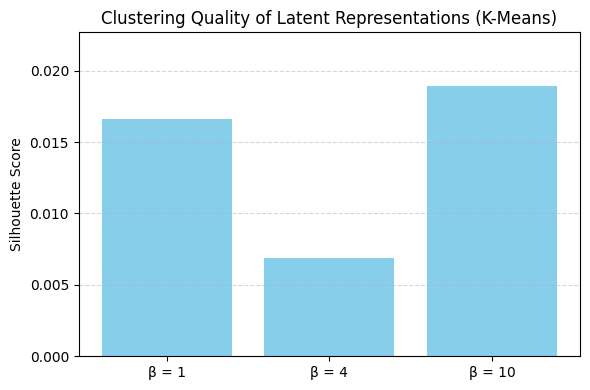

In [60]:
import matplotlib.pyplot as plt

# Example silhouette_scores dictionary
silhouette_scores = {1: 0.0166, 4: 0.0069, 10: 0.0189}

# Plotting
plt.figure(figsize=(6, 4))
plt.bar([f"β = {k}" for k in silhouette_scores], silhouette_scores.values(), color="skyblue")
plt.ylabel("Silhouette Score")
plt.title("Clustering Quality of Latent Representations (K-Means)")
plt.ylim(0, max(silhouette_scores.values()) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Evaluating Latent Separability with Random Forest Classification

We now evaluate the semantic separability of the latent space using a **Random Forest classifier**.

---
Random forests

- Handle **multi-class classification** natively
- Work well with **imbalanced and noisy datasets**
- Capture **non-linear feature interactions** without requiring heavy tuning
- Robust to outliers and insensitive to data scaling


---

For each ß value (ß = 1, 4, 10):

1. Use the VAE's latent vectors as features
2. Train a `RandomForestClassifier` on 70% of the data
3. Evaluate accuracy on the remaining 30%
4. Visualize the confusion matrix to identify dominant and confused classes


ß = 1: Random Forest Accuracy = 0.3497


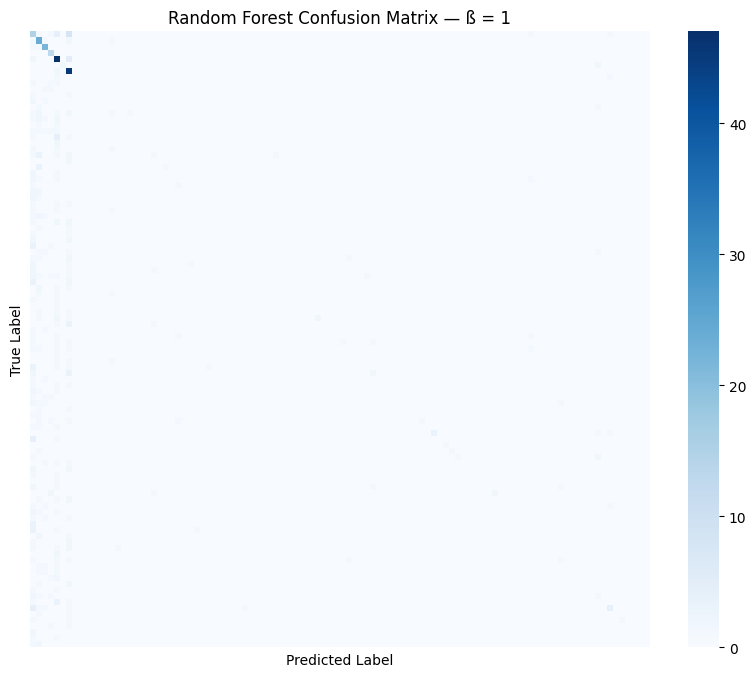

ß = 4: Random Forest Accuracy = 0.3370


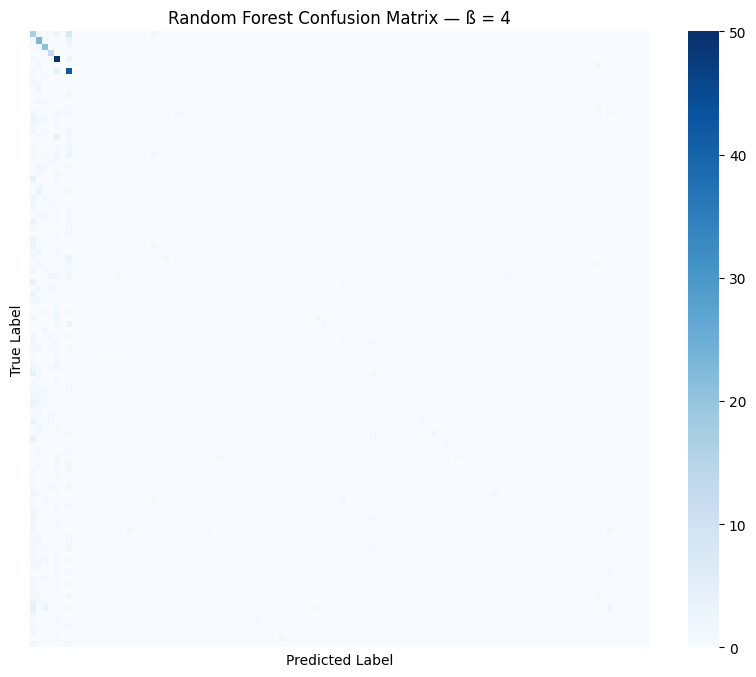

ß = 10: Random Forest Accuracy = 0.3552


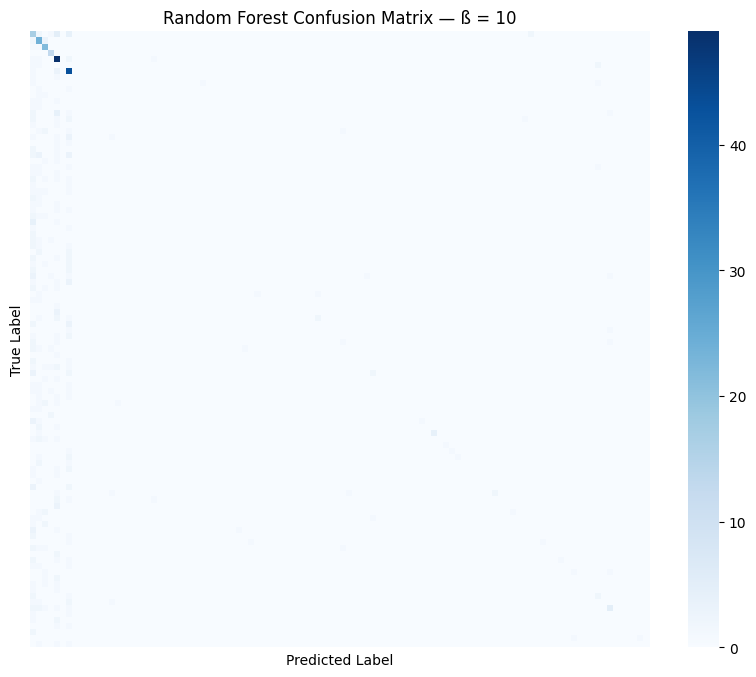

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

rf_accuracies = {}

def plot_confusion_matrix_rf(y_true, y_pred, beta_value):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
    plt.title(f"Random Forest Confusion Matrix — ß = {beta_value}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

for beta, (mu, labels) in latent_data.items():
    #dataset splitting
    X_train, X_test, y_train, y_test = train_test_split(
        mu, labels, test_size=0.3, stratify=labels, random_state=42
    )

    #training
    rf = RandomForestClassifier(n_estimators=100, random_state=42) #I choose n estimator hyperparameter 200 for better accuracy
    rf.fit(X_train, y_train)

    #predict and evaluate
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rf_accuracies[beta] = acc

    print(f"ß = {beta}: Random Forest Accuracy = {acc:.4f}")
    plot_confusion_matrix_rf(y_test, y_pred, beta)


### Moving to a Focused (Top-10) Confusion Matrix

While the full 101×101 confusion matrices offer a complete view, they are:

- **Too sparse** to interpret visually
- **Overwhelmed** by the long tail of underrepresented classes
- Not effective for highlighting meaningful patterns

To better analyze semantic separation and model confusion, we now focus on the **Top-N most frequent classes**. In this case it will be top-10. This allows:

- More **readable, structured heatmaps**
- A clearer view of which classes are separable in latent space
- Improved interpretability across ß values


ß = 1 — Top 10 Class Confusion Matrix


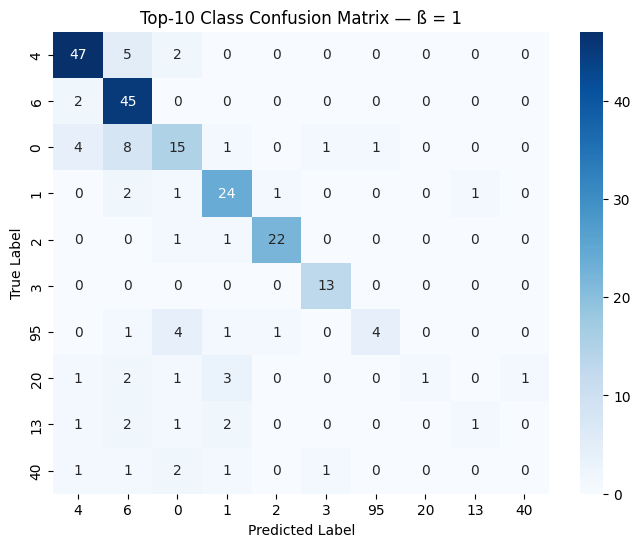

ß = 4 — Top 10 Class Confusion Matrix


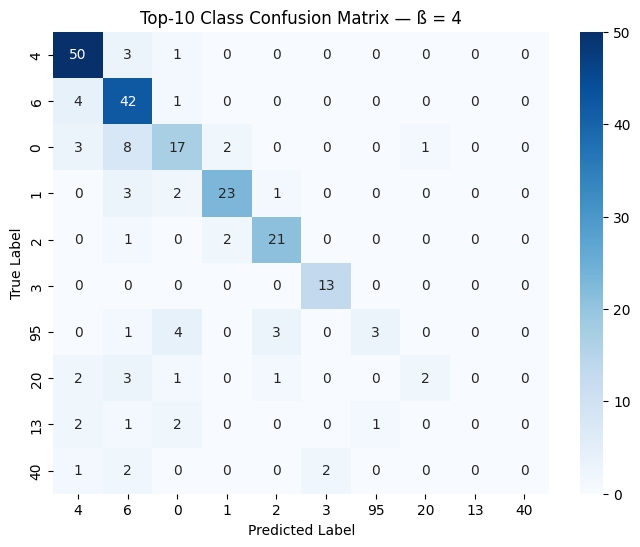

ß = 10 — Top 10 Class Confusion Matrix


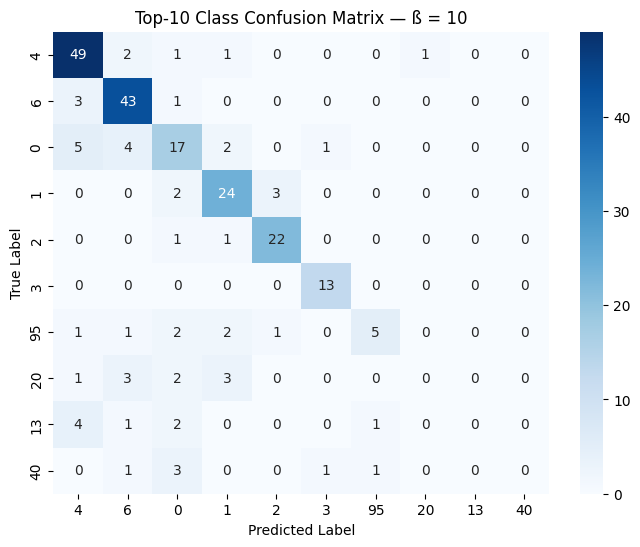

In [49]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_top_10_confusion_matrix(y_true, y_pred, top_classes, beta_value):
    mask = np.isin(y_true, top_classes) & np.isin(y_pred, top_classes)
    y_true_top = np.array(y_true)[mask]
    y_pred_top = np.array(y_pred)[mask]

    remap = {cls: idx for idx, cls in enumerate(top_classes)}
    y_true_mapped = [remap[label] for label in y_true_top]
    y_pred_mapped = [remap[label] for label in y_pred_top]

    
    cm = confusion_matrix(y_true_mapped, y_pred_mapped)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_classes, yticklabels=top_classes)
    plt.title(f"Top-10 Class Confusion Matrix — ß = {beta_value}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

#looping over each ß
for beta, (mu, labels) in latent_data.items():
    #splitting dataset
    X_train, X_test, y_train, y_test = train_test_split(
        mu, labels, test_size=0.3, stratify=labels, random_state=42
    )

    #top 10
    top_10_classes = [cls for cls, _ in Counter(y_test).most_common(10)]

    #RF train
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    #plot
    print(f"ß = {beta} — Top 10 Class Confusion Matrix")
    plot_top_10_confusion_matrix(y_test, y_pred, top_10_classes, beta)


### Top-10 Class Confusion Matrices

To provide **clearer insight into semantic separability**, we focused on the 10 most frequent categories in the dataset.

These confusion matrices show:
- Reasonably strong **diagonal dominance**
- **Consistent structure** across ß values—suggesting that the latent encodings preserve essential class distinctions.
- Some off diagonal confusion especially among visually or structurally similar classes (?), which is expected given the unsupervised nature of VAEs.

---

Comparing different ß values their performance were similar.

---

Global class separation is difficult (due to dataset size and class overlap as we see in PCA projections), the learned representations **retain enough structure** to support meaningful discrimination among high frequency categories.

I also want to evaulate with one more model which can operate better on high dimensional non linearly seperable data.

### Evaluating Non-Linear Separability with Multi-Layer Perceptron

While linear classifiers like Random Forests provide insight into **basic class separability** in the latent space, they may not fully capture complex, non linear structures.

---

- **Input**: Posterior mean vectors (`μ`) from each ß-VAE model.
- **Training**: Supervised learning on true class labels.
- **Goal**: Evaluate how well non linear models can distinguish object categories based on latent encodings.

---

This offers a more complete picture of **semantic structure** in the latent space:
- If the MLP performs better than RF, it suggests **non linear separability**.
- If it performs similarly, it confirms that the latent space itself is inherently limited in discriminative power.


In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

mlp_accuracies = {}

def plot_mlp_confusion_matrix(y_true, y_pred, beta_value):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
    plt.title(f"MLP Confusion Matrix — ß = {beta_value}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

for beta, (mu, labels) in latent_data.items():
    #dplit data
    X_train, X_test, y_train, y_test = train_test_split(
        mu, labels, test_size=0.3, stratify=labels, random_state=42
    )

    #train MLP
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=300, random_state=42) #3 layer
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    #accuracy scores
    acc = accuracy_score(y_test, y_pred)
    mlp_accuracies[beta] = acc
    print(f"ß = {beta}: MLP Accuracy = {acc:.4f}")

ß = 1: MLP Accuracy = 0.3825
ß = 4: MLP Accuracy = 0.3752
ß = 10: MLP Accuracy = 0.3752


### Comparative Evaluation of Latent Space Using Multiple Classifiers

To assess how semantically meaningful the learned latent representations are, we evaluated the class-separability of the **posterior mean vectors** (`μ`) using three different classifiers:

- **Random Forest** ensemble of decision trees
- **Multi-layer Perceptron** non-linear neural network

This approach allows us to compare how each β-VAE’s latent space encodes abstract category information, both in linear and non-linear settings.

---

#### Classification Accuracy Summary:

| β Value | RF Accuracy |MLP Accuracy |
|---------|-------------|-------------|
| β = 1   | 0.349       | **0.382**   |
| β = 4   | 0.337       | **0.375**   |
| β = 10  | 0.355       | **0.375**   |

---

- **MLP consistently outperforms** Random Forest, implying the presence of **non linear decision boundaries** in the latent space.
- **β = 1** leads to the most semantically usable latent codes across both classifiers, suggesting better class specific structure since it is less subject of abstraction.
- As β increases, abstraction may increase but **semantic alignment degrades**, making classification harder.

---

### VAE Under Noise

To simulate this in our generative model:
- We will present **Gaussian noise** into the input images at varying intensities 0.1 to 0.5
- We measure the **reconstruction error (MSE)** for each noise level
- It is usefull to asses **how robust the model's perceptual system is** to degraded sensory input.

---

- At low noise, both the brain and the model rely heavily on **bottom-up detail**.
- At higher noise, reconstruction depends increasingly on **top down priors and expectations**.

---

By plotting **MSE vs. noise level** we can compare the robustness across ß values and observe how abstraction trades off with perceptual sensitivity.

In [ ]:
#increasing gaussian noise

def evaluate_reconstruction_under_noise(model, dataloader, device, noise_levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5], num_batches=5):
    model.eval()
    noise_losses = []

    with torch.no_grad():
        for sigma in noise_levels:
            total_loss = 0
            count = 0

            for i, (images, _) in enumerate(dataloader):
                if i >= num_batches:
                    break

                images = images.to(device)
                noise = torch.randn_like(images) * sigma
                noisy_images = torch.clamp(images + noise, 0.0, 1.0)

                recon, _, _ = model(noisy_images)
                loss = funct.mse_loss(recon, images)
                total_loss += loss.item()
                count += 1

            avg_loss = total_loss / count
            noise_losses.append(avg_loss)

    return noise_levels, noise_losses

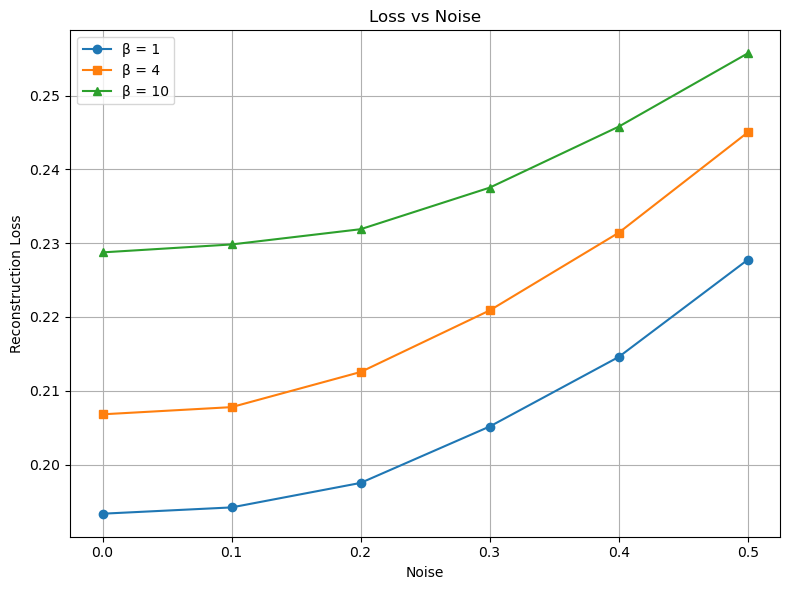

In [ ]:
noise_levels, losses_b1_noise = evaluate_reconstruction_under_noise(vae_b1_30, test_loader, device)
noise_levels, losses_b4_noise = evaluate_reconstruction_under_noise(vae_b4_30, test_loader, device)
noise_levels, losses_b10_noise = evaluate_reconstruction_under_noise(vae_b10_30, test_loader, device)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(noise_levels, losses_b1_noise, marker='o', label='ß = 1')
plt.plot(noise_levels, losses_b4_noise, marker='s', label='ß = 4')
plt.plot(noise_levels, losses_b10_noise, marker='^', label='ß = 10')

plt.title("Loss vs Noise")
plt.xlabel("Noise")
plt.ylabel("Reconstruction Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



The plot above shows how reconstruction loss (MSE) changes as Gaussian noise increases in the input, across three models trained with different ß values (1, 4, and 10).

---

- **All models show increasing loss** as input noise rises, as expected. This reflects decreasing perceptual clarity.
- **ß = 1** maintains the lowest loss at every noise level. This makes sense, it prioritizes **reconstruction fidelity** in its training objective.
- **ß = 4 and ß = 10** show higher initial loss and steeper degradation. These models emphasize **latent structure** and abstraction. So they're more sensitive to sensory corruption.


---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3751835..0.98492813].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.31452504..0.9364967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3189844..0.9346993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46596485..0.9959082].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4119842..0.97831106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12113601..0.91122395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

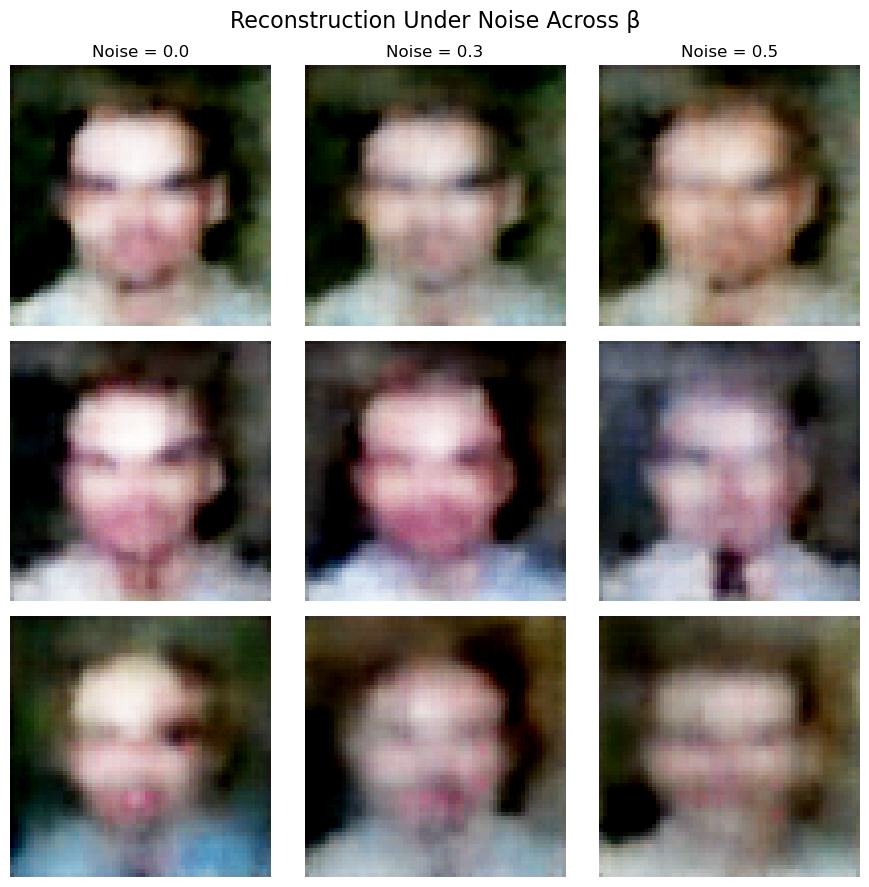

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

#retrieving one image to asses better
img, _ = next(iter(test_loader))
img = images[random.randint(0, len(images)-1)].unsqueeze(0).to(device)

#models and their labels
models = [vae_b1_30, vae_b4_30, vae_b10_30]
labels = ["ß = 1", "ß = 4", "ß = 10"]
noise_levels = [0.0, 0.3, 0.5]

# Create plot grid
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, model in enumerate(models):
    model.eval()
    for j, sigma in enumerate(noise_levels):
        noisy = torch.clamp(img + sigma * torch.randn_like(img), 0.0, 1.0)
        with torch.no_grad():
            recon, _, _ = model(noisy)
        axes[i, j].imshow(recon[0].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, j].axis("off")

        if i == 0:
            axes[i, j].set_title(f"Noise = {sigma}")

plt.suptitle("Reconstruction Under Noise Across ß", fontsize=16)
plt.tight_layout()
plt.show()

### Reconstructions Under Noise

This grid compares how different ß-VAE models reconstruct the **same input image** under **increasing levels of Gaussian noise**. It provides a qualitative view of the model's robustness and abstraction ability.

---

- **Each row represents a different model**:
  - **Top row**: ß = 1
  - **Middle row**: ß = 4
  - **Bottom row**: ß = 10

- **Each column increases noise added to the input image**

---

### Adversarial Sensitivity in VAE

In classification models, adversarial attacks typically aim to manipulate inputs with small and often consequences the model to misclassify. These attacks exploit weaknesses in the model’s decision boundaries.

But VAEs are **not classifiers**. Instead, they encode and reconstruct input data through a latent space. So how do adversarial concepts apply to VAEs?

---

In VAEs, an “adversarial” perturbation might not cause a wrong class label, but it **can lead to dramatically different reconstructions** from inputs that appear almost identical to the human eye.

This might mirror :
> **Perceptual illusions and hallucinations** occur when the brain interprets noisy or ambiguous input in strongly divergent ways, based on its internal priors.

---

We can also explore how VAE would act on adversarial attack. To do so in order to keep previous results I will train another model on a simplified dataset. If the outputs differ sharply from one another, it reflects the VAE’s **perceptual instability**.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random

#transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
#defining another VAE, basically what I did in the initial code cells

import torch.nn as nn
import torch.nn.functional as funct

class SmallVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(32 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(32 * 16 * 16, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 32 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 16, 16)),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_decoded = self.decoder_input(z)
        x_recon = self.decoder(h_decoded)
        return x_recon, mu, logvar


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_vae = SmallVAE().to(device)
optimizer_small = torch.optim.Adam(small_vae.parameters(), lr=1e-3)

In [ ]:
#training the modelfor adversarial evaluation

small_vae = SmallVAE(latent_dim=64).to(device)
opt_small_vae = torch.optim.Adam(small_vae.parameters(), lr=1e-3)

losses_small_vae = train_vae(
    model=small_vae,
    dataloader=train_loader,
    optimizer=opt_small_vae,
    device=device,
    beta=1,
    epochs=30
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].


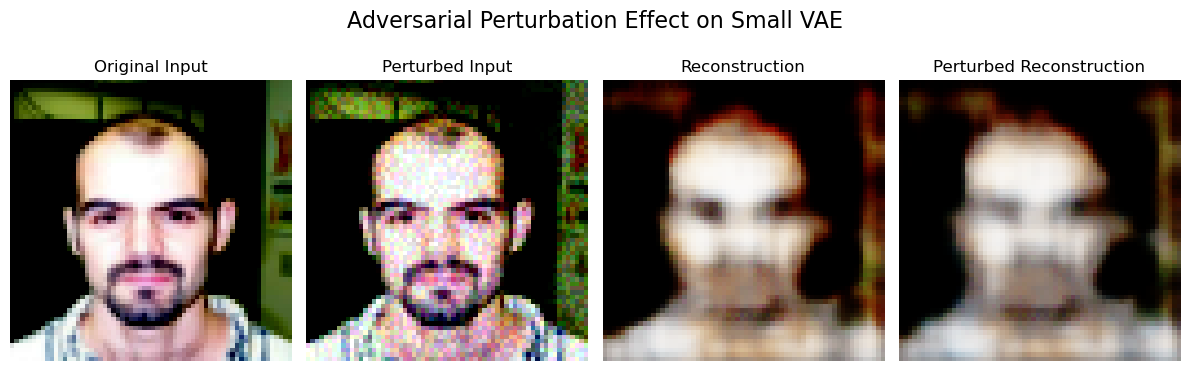

In [ ]:
#model to evaluate
small_vae.eval()

#retrieving image to evaluate
sample_img, _ = next(iter(subset_loader))
img = images[random.randint(0, len(images)-1)].unsqueeze(0).to(device)

#Adversarial Perturbation
epsilon = 0.09
img_perturbed = img + epsilon * torch.sign(torch.randn_like(img))
img_perturbed = torch.clamp(img_perturbed, 0.0, 1.0)

#Reconstruction
with torch.no_grad():
    recon_clean, _, _ = small_vae(img)
    recon_perturbed, _, _ = small_vae(img_perturbed)

#plotting
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

axs[0].imshow(img[0].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axs[0].set_title("Original Input")

axs[1].imshow(img_perturbed[0].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axs[1].set_title("Perturbed Input")

axs[2].imshow(recon_clean[0].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axs[2].set_title("Reconstruction")

axs[3].imshow(recon_perturbed[0].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axs[3].set_title("Perturbed Reconstruction")

for ax in axs:
    ax.axis("off")

plt.suptitle("Adversarial Perturbation Effect on Small VAE", fontsize=16)
plt.tight_layout()
plt.show()


### Adversarial Perturbation Effects on VAE Reconstructions

Our case seems robust.

In the visualization above, we explore how trained VAE responds to an adversarially perturbed input. The **Original Input** and **Perturbed Input** look nearly identical to the human eye the pixel level noise is visible. Despite this, the VAE processes them and reconstructs both images with only **slight variation**.

- This output example shows **relative stability in the VAE's reconstructions**.
- The **latent representations** of the perturbed input do not seem to deviate far from the original, suggesting that the VAE has captured a **more robust encoding** for this input.

This outcome illustrates that generative models like VAEs **can resist perturbations** under certain conditions. especially when the input is well represented in the training distribution.

It also suggests that **not all adversarial perturbations cause catastrophic failure**, and the **severity of output degradation** depends on the interaction between the input, perturbation, and the model's latent space structure.

### Final Summary and Takeaways

This project investigated the generative nature of visual perception using Variational Autoencoders (VAEs) and their ß-VAE extensions, trained on a Caltech 101 dataset.

We explored how varying the ß hyperparameter influences:
- The trade off between **reconstruction fidelity** and **latent structure disentanglement**
- Model robustness under **noisy** and **adversarial perturbations**
- The **internal representations** and their ability to capture abstract visual features

---

- **Low ß values** keeps fine details and almost like one to one retinotopic map in reconstructions, but struggle to form clean, interpretable latent spaces.

- **Higher ß values** enforce stronger regularization, leading to blurrier reconstructions that often reflect **internal priors** more than exact inputs.

- **Noisy input experiments** show that ß-VAEs can maintain structural integrity even under significant corruption, though higher ß models are more sensitive to input perturbation.

- In **adversarial attack scenarios**, small imperceptible changes lead to distortions but in our case, our model was relatively showed robust characteristics.


---

This project highlights how the ß-VAE not only serves as a powerful generative model but also offers a view into the computational aspect of human perception, from low level pixel reconstruction to high level abstract reasoning.
